#Downloading the Dataset

In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print(f"User uploaded file {fn} with length {len(uploaded[fn])}")

#Move kaggle.json into the folder where the API expects to find it
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file kaggle.json with length 69


In [2]:
!kaggle datasets download -d shawon10/ckplus

  0% 0.00/3.63M [00:00<?, ?B/s]
100% 3.63M/3.63M [00:00<00:00, 65.2MB/s]


In [3]:
import zipfile
file_name = "/content/ckplus.zip"
with zipfile.ZipFile(file_name,"r") as zip_ref:
  zip_ref.extractall()
  print(f"Done")

Done


In [4]:
import os
os.listdir("CK+48")

['anger', 'contempt', 'disgust', 'happy', 'sadness', 'surprise', 'fear']

creating train and test directories

In [5]:
from sklearn.model_selection import train_test_split
import shutil
dataset_dir = "CK+48"

train_dir = "train"
test_dir = "test"

os.makedirs(train_dir,exist_ok = True)
os.makedirs(test_dir , exist_ok = True)

for label in os.listdir(dataset_dir):
  class_dir = os.path.join(dataset_dir,label)

  train_label_dir = os.path.join(train_dir,label)
  test_label_dir = os.path.join(test_dir,label)
  os.makedirs(train_label_dir , exist_ok = True)
  os.makedirs(test_label_dir , exist_ok = True)

  file_names = os.listdir(class_dir)

  train_files , test_files = train_test_split(file_names , test_size = 0.2)

  for file_name in train_files:
    src_path = os.path.join(class_dir , file_name)
    dst_path = os.path.join(train_label_dir,file_name)
    shutil.copy(src_path,dst_path)

  for file_name in test_files:
    src_path = os.path.join(class_dir,file_name)
    dst_path = os.path.join(test_label_dir,file_name)
    shutil.copy(src_path,dst_path)

Visualizing an Image

Image label : surprise
Image size : (48, 48)


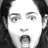

In [6]:
import random
from PIL import Image
random.seed(42)
import random
from pathlib import Path
image_path = Path("train/")

image_path_list = list(image_path.glob("*/*/"))

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem


img = Image.open(random_image_path)

print(f"Image label : {image_class}")
print(f"Image size : {img.size}")
img


Converting to Numpy for Visualization in matplotlib

(-0.5, 47.5, 47.5, -0.5)

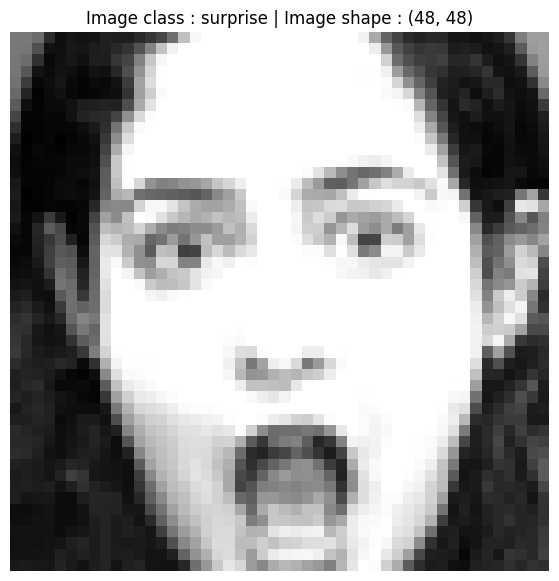

In [7]:
import matplotlib.pyplot as plt
import numpy as np

img_as_array = np.asarray(img)
plt.figure(figsize=(10,7))
plt.imshow(img_as_array,cmap = "gray")
plt.title(f"Image class : {image_class} | Image shape : {img_as_array.shape}")
plt.axis("off")

In [8]:
import torch
import torch.nn as nn

#Creating TinyVGG Model

In [9]:
class TinyVGG(nn.Module):
  def __init__(self,input_shape,
               hidden_units,output_shape):
    super().__init__()
    self.conv_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape,
                  out_channels = hidden_units,
                  kernel_size = 3, stride = 1 , padding = 0),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3 , stride = 1 , padding = 0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2 , stride = 1),
    )

    self.conv_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3 , stride = 1 , padding = 0),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3 , stride = 1 , padding = 0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2 , stride = 2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_units,
                  out_features = output_shape),
    )

  def forward(self,x):
    x = self.conv_1(x)
    x = self.conv_2(x)
    x = self.classifier(x)
    return x

In [10]:
def find_classes(directory):
  #Finds the class folder names in a target directory
  #Get the class names by scanning the target directory
  classes =  sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  #Create a dictionary of index labels (computer prefer numbers rather than strings as labels)
  class_to_idx = {class_names : i for i,class_names in enumerate (classes)}
  return classes,class_to_idx

In [11]:
from torch.utils.data import Dataset

class ImageFolderCustom(Dataset):
  def __init__(self,targ_dir,transform):
    self.paths = list(Path(targ_dir).glob("*/*"))

    self.transform = transform

    self.classes , self.class_to_idx = find_classes(targ_dir)

  #Create a function to load images
  def load_images(self,index):
    image_path = self.paths[index]
    return Image.open(image_path)

  #Return the length
  def __len__(self):
    return len(self.paths)

  #__getitem__() method to return a particular sample
  def __getitem__(self,index):
    #Return one sample of data , data and label
    img = self.load_images(index)
    class_name = self.paths[index].parent.name
    class_idx = self.class_to_idx[class_name]

    if self.transform:
      return self.transform(img) , class_idx
    else:
      return img,class_idx


In [12]:
#Create a transform

from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [13]:
train_data_custom = ImageFolderCustom(targ_dir = train_dir,
                                      transform = train_transforms)

test_data_custom = ImageFolderCustom(targ_dir = test_dir,
                                     transform = test_transforms)

In [14]:
class_names = train_data_custom.classes

In [15]:
torch.manual_seed(42)

model_0 = TinyVGG(input_shape = 1,
                  hidden_units = 10,
                  output_shape = len(class_names))

In [16]:
model_0

TinyVGG(
  (conv_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=10, out_features=7, bias=True)
  )
)

In [17]:
#Turn Datasets into DataLoaders
from torch.utils.data import DataLoader
BATCHES = 32
NUM_WORKERS = os.cpu_count()


train_dataloader = DataLoader(dataset = train_data_custom,
                    batch_size = BATCHES,
                    num_workers = NUM_WORKERS,
                    shuffle = True,)

test_dataloader = DataLoader(dataset = test_data_custom,
                   batch_size = BATCHES,
                   num_workers = NUM_WORKERS,
                   shuffle = True)


In [18]:
image_batch , label_batch = next(iter(train_dataloader))


torch.Size([32, 1, 64, 64])

In [20]:
print(f"Image_batch shape is {image_batch.shape} , Label_batch shape is {label_batch.shape}")

Image_batch shape is torch.Size([32, 1, 64, 64]) , Label_batch shape is torch.Size([32])


In [23]:
class_names = train_data_custom.classes
class_idx = train_data_custom.class_to_idx
class_idx , class_names

({'anger': 0,
  'contempt': 1,
  'disgust': 2,
  'fear': 3,
  'happy': 4,
  'sadness': 5,
  'surprise': 6},
 ['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise'])

Plotting the transformed image

In [40]:
def plot_transformed_images(image_path , k , transform , seed):
  random.seed(42)
  random_image = random.sample(image_path , k)
  for i in random_image:
    with Image.open(i) as f:
      fig , ax = plt.subplots(nrows = 1 , ncols = 2)
      ax[0].imshow(f,cmap="gray")
      ax[0].axis(False)

      transformed_image = transform(f).permute(1,2,0)
      ax[1].imshow(transformed_image,cmap = "gray")
      ax[1].axis(False)

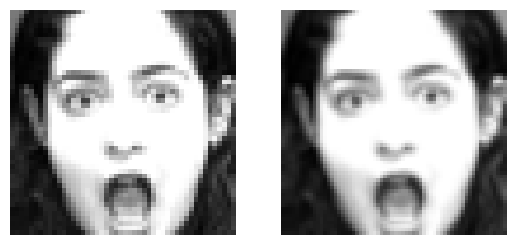

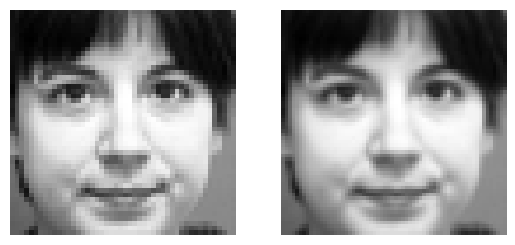

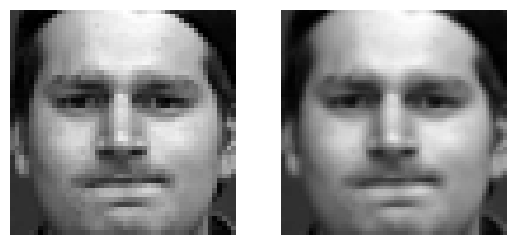

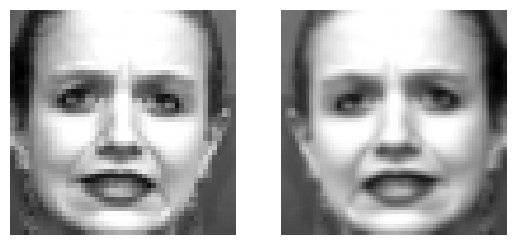

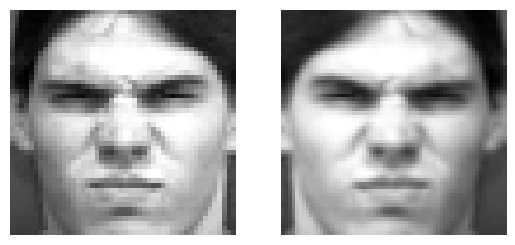

In [41]:
plot_transformed_images(image_path_list,5,train_transforms,42)

In [42]:
#Create a function to take in a dataset
def display_random_images(dataset , classes , n , seed):

  #Setting up random seed
  random.seed(seed)

  #Get random sample indexes
  random_sample_idx = random.sample(range(len(dataset)),k=n)

  #Setting up matplotlib
  plt.figure(figsize=(16,8))

  #set up plot
  for i , targ_sample in enumerate(random_sample_idx):
    targ_image , targ_label = dataset[targ_sample][0] , dataset[targ_sample][1]
    targ_image_adjust = targ_image.permute(1,2,0) # [height,width,color_channels]

    plt.subplot(1,n,i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")

    if classes:
      title = f"Class : {classes[targ_label]}"
      #if display_shape:
        #title = title + f"\nshape : {targ_image_adjust.shape}"
    plt.title(title)


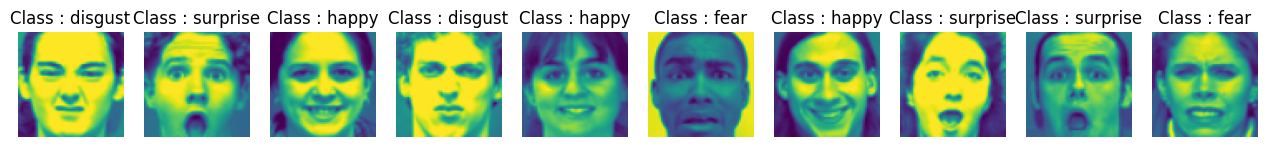

In [43]:
display_random_images(train_data_custom , class_names , 10 , seed = None)